In [1]:
import requests

from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c
from PIL import Image

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi

In [2]:
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

In [3]:
# Read in the table of galaxies that have been put into clusters

SGA = Table.read('SGA-2020_jura_Vrot_cluster_calib_VI.fits')
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,MORPHTYPE_AI,CLUSTER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,bytes10,int32
2056,SGA-2020 2056,PGC3090638,3090638,193.6930065,15.5916891,I,3.24,0.42953643,0.76736146,0.008800754,23.633482,16.84,False,LEDA-20181114,585,PGC3090638,1,True,193.6930065,15.5916891,0.42953643,1935p155,193.69299749312026,15.591724570040274,0.48851982,SB26,11.668644,0.71603954,193.69289191559892,15.591839847613839,11.774455,4.3058023,4.495752,4.616412,4.9170485,6.18269,7.3138824,8.316136,9.319301,10.374897,11.635473,13.073705,14.655595,17.134708,16.869791,16.704203,16.90455,16.627546,16.45877,16.776154,16.492624,16.320917,16.705257,16.416267,16.241508,16.658772,16.36552,16.185635,16.627045,16.330387,16.145723,16.600666,16.302883,16.113653,16.582727,16.281683,16.092112,16.56931,16.263586,16.071106,0.024651717,0.025509562,0.021021688,0.025019383,0.03921681,0.056336682,0.063054726,0.08825987,0.12649716,0.015854347,0.013339996,0.011880502,0.013634203,0.011504582,0.010417499,0.01244435,0.010522052,0.009550867,0.011776679,0.009949894,0.009043998,0.011338439,0.009571019,0.00871683,0.011039947,0.009308954,0.008486015,0.01077

In [4]:
### Return a list of which galaxies were put into more than 1 cluster


unique, counts = np.unique(SGA['SGA_ID'], return_counts=True)

dups = unique[counts > 1]

print(dups)

 SGA_ID
-------
 119118
 382060
 448156
 559486
 573864
 618981
 746574
 757003
 838579
 903508
 910721
1081088
1179880
1271973
1285640
1363075


In [6]:
### Print a list of the clusters that these galaxies belong in 

duplicates = SGA[np.isin(SGA['SGA_ID'], dups)]
duplicates.sort('SGA_ID')
duplicates

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,MORPHTYPE_AI,CLUSTER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,bytes10,int32
119118,SGA-2020 119118,PGC1310038,1310038,229.32858299999995,6.915014,Scd,46.1,0.5495409,0.38018942,0.033176616,24.346481,17.018,False,LEDA-20181114,41000,PGC1310038,1,True,229.32858299999995,6.915014,0.5495409,2292p070,229.3286724707474,6.915034412134718,0.93967575,SB26,45.181507,0.34080625,229.32848947711068,6.915045501535101,21.9074,10.3336115,9.943433,10.786739,5.1613426,7.882382,11.034888,13.957835,16.654486,19.06577,21.684492,24.598614,28.190273,18.42777,17.8313,17.461678,17.869534,17.290594,16.903067,17.472595,16.903221,16.521055,17.215487,16.661655,16.284067,17.043741,16.50327,16.130936,16.961536,16.42144,16.035414,16.90534,16.369667,15.971991,16.860533,16.334663,15.92253,16.826933,16.299023,15.879286,0.06614689,0.1307701,0.16542947,0.22082387,0.19740479,0.15969206,0.18361232,0.20145175,0.27535164,0.02697335,0.029765472,0.029942036,0.023942705,0.025673838,0.025807166,0.022099566,0.023304773,0.023073824,0.020944085,0.021773575,0.02132361,0.01992916,0.020510131,0.020123566,0.019117182,0.019620024,0.019218696,0.

In [7]:
### Return a list of which clusters are effected by this, and how many galaxies they have that overlap with another.


unique, counts = np.unique(duplicates['CLUSTER_ID'], return_counts=True)

cluster_probs = unique[counts > 1]

for cluster, count in zip(cluster_probs, counts[counts > 1]):
    print(f"Cluster ID: {cluster}, Count: {count}")

Cluster ID: 100004, Count: 2
Cluster ID: 100041, Count: 2
Cluster ID: 100049, Count: 5
Cluster ID: 100282, Count: 2
Cluster ID: 100302, Count: 5
Cluster ID: 100952, Count: 2
Cluster ID: 101400, Count: 5
Cluster ID: 101823, Count: 5


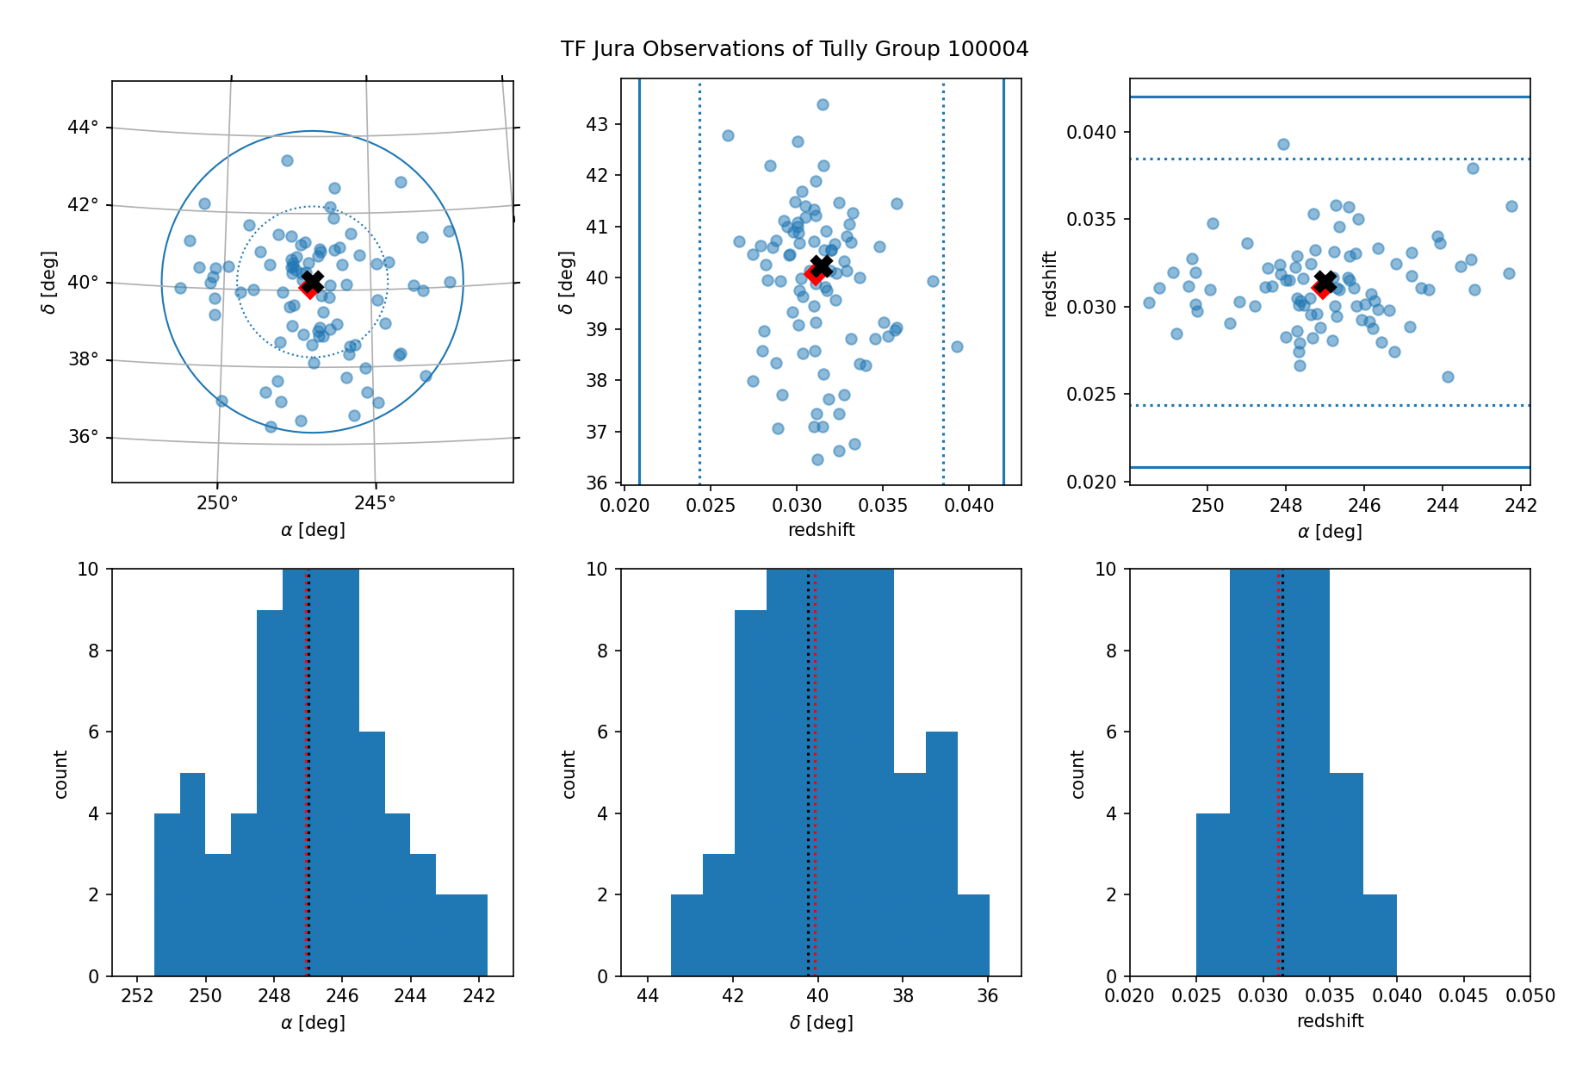

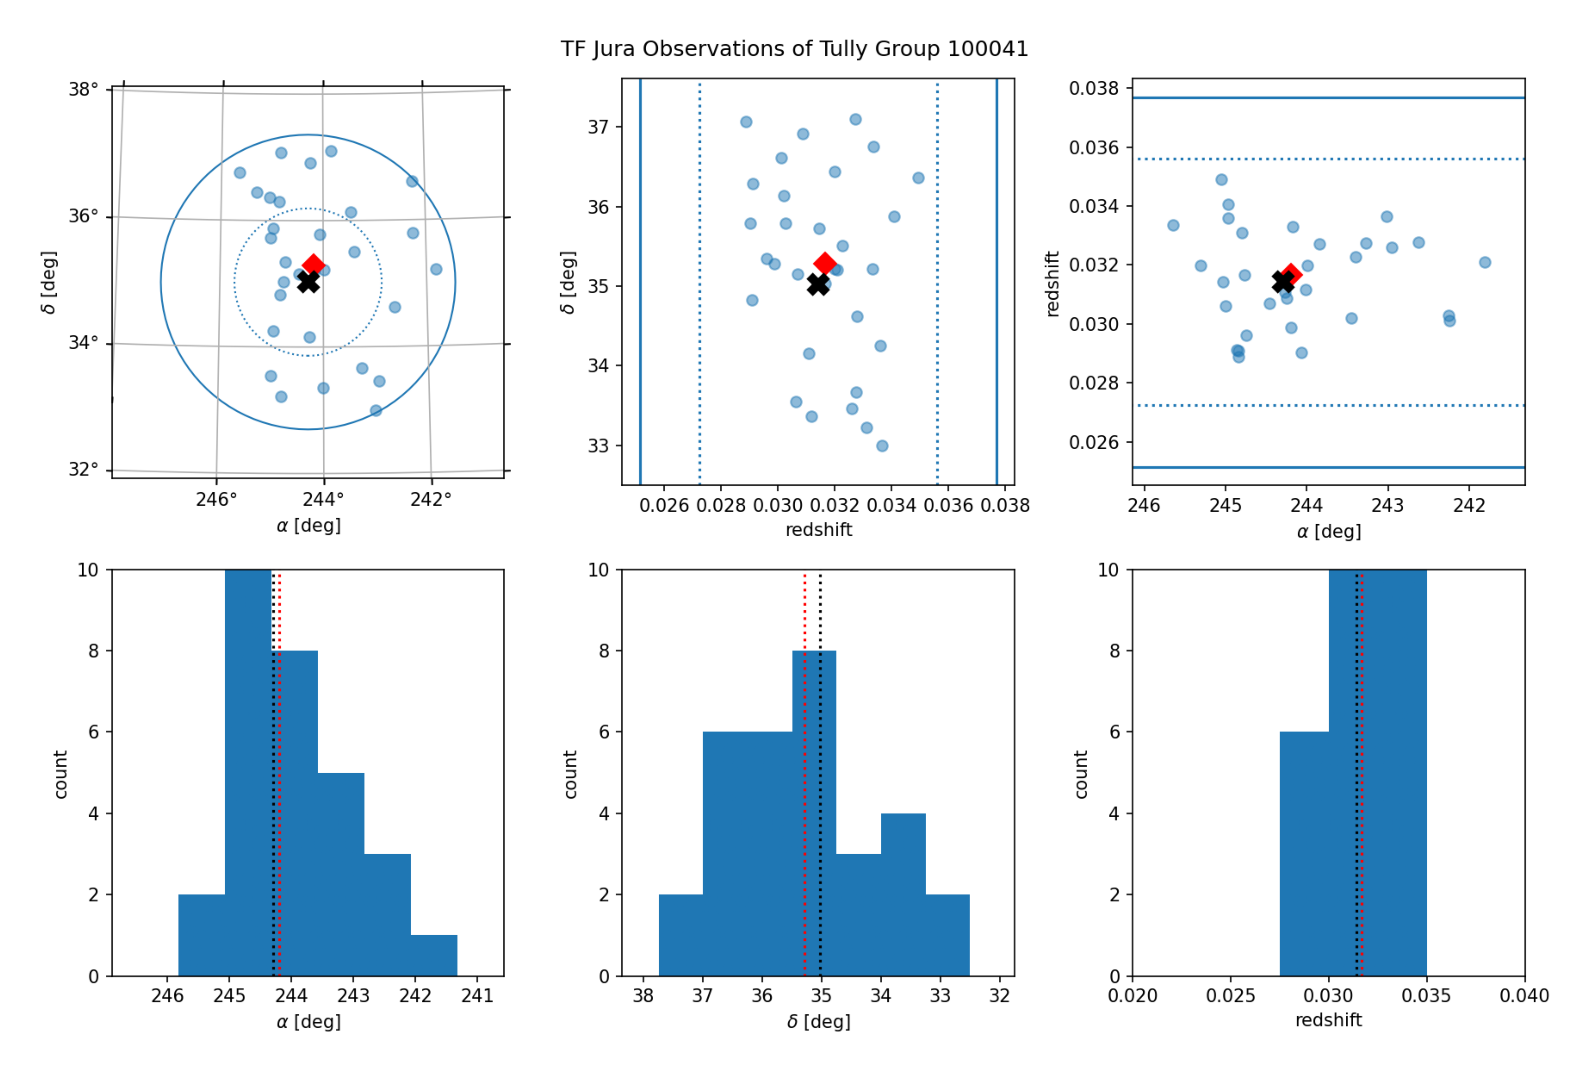

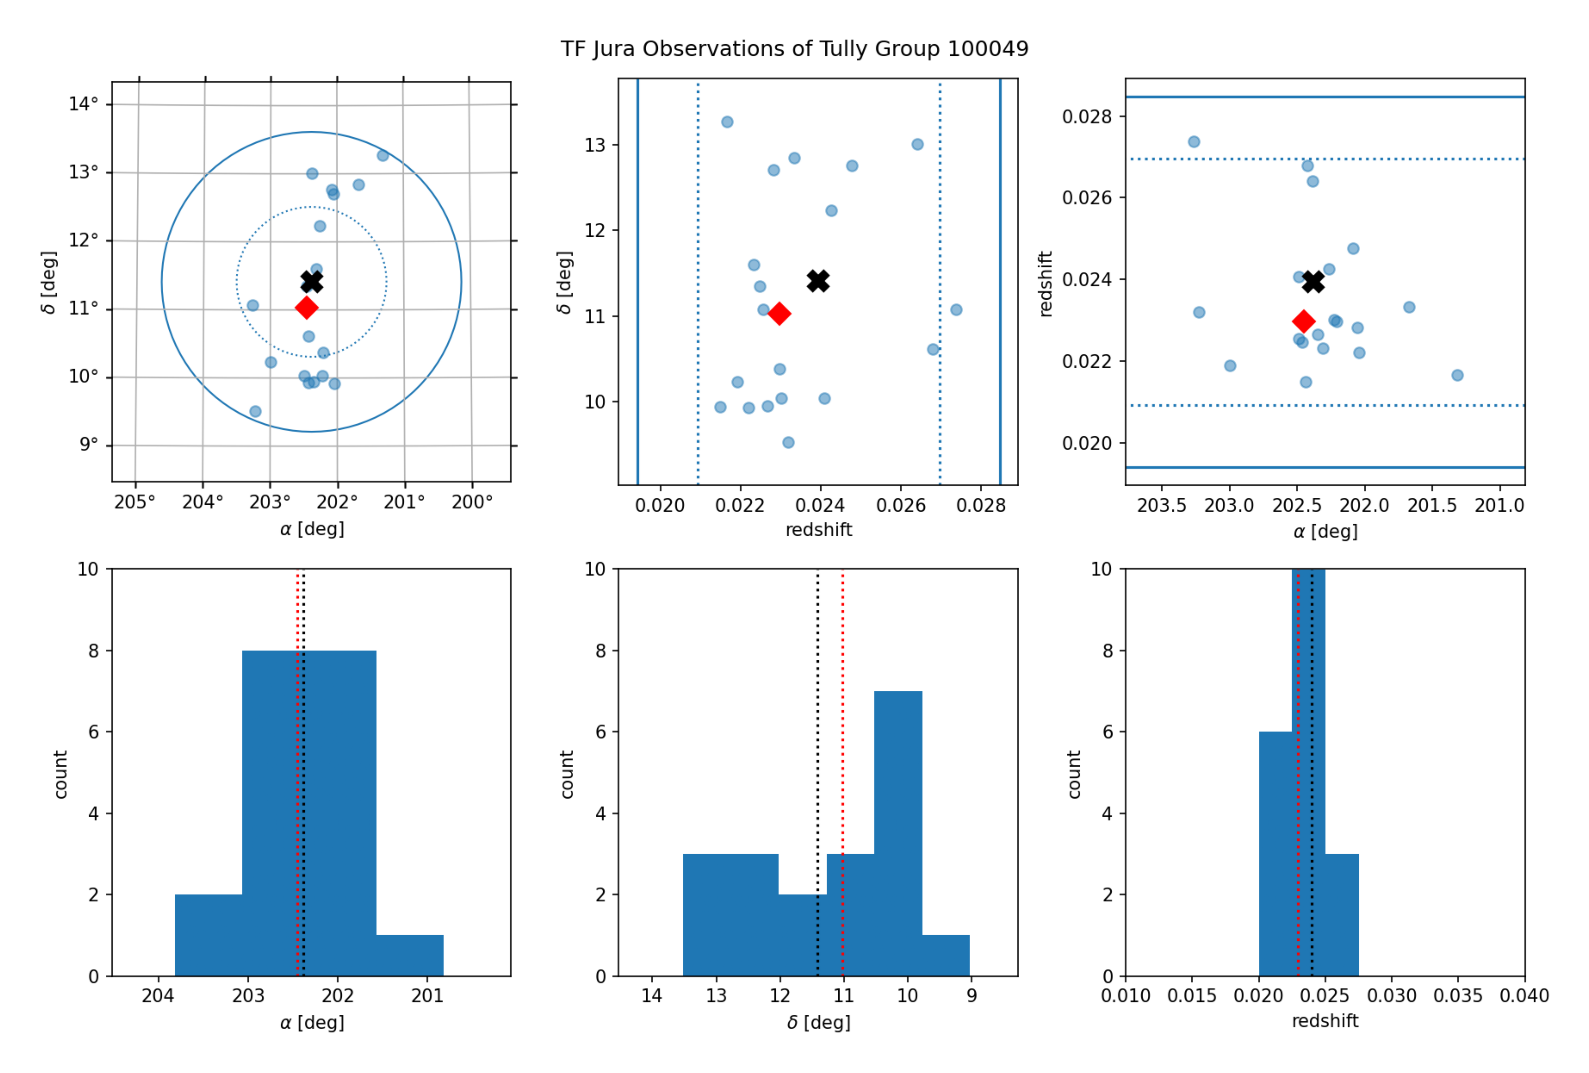

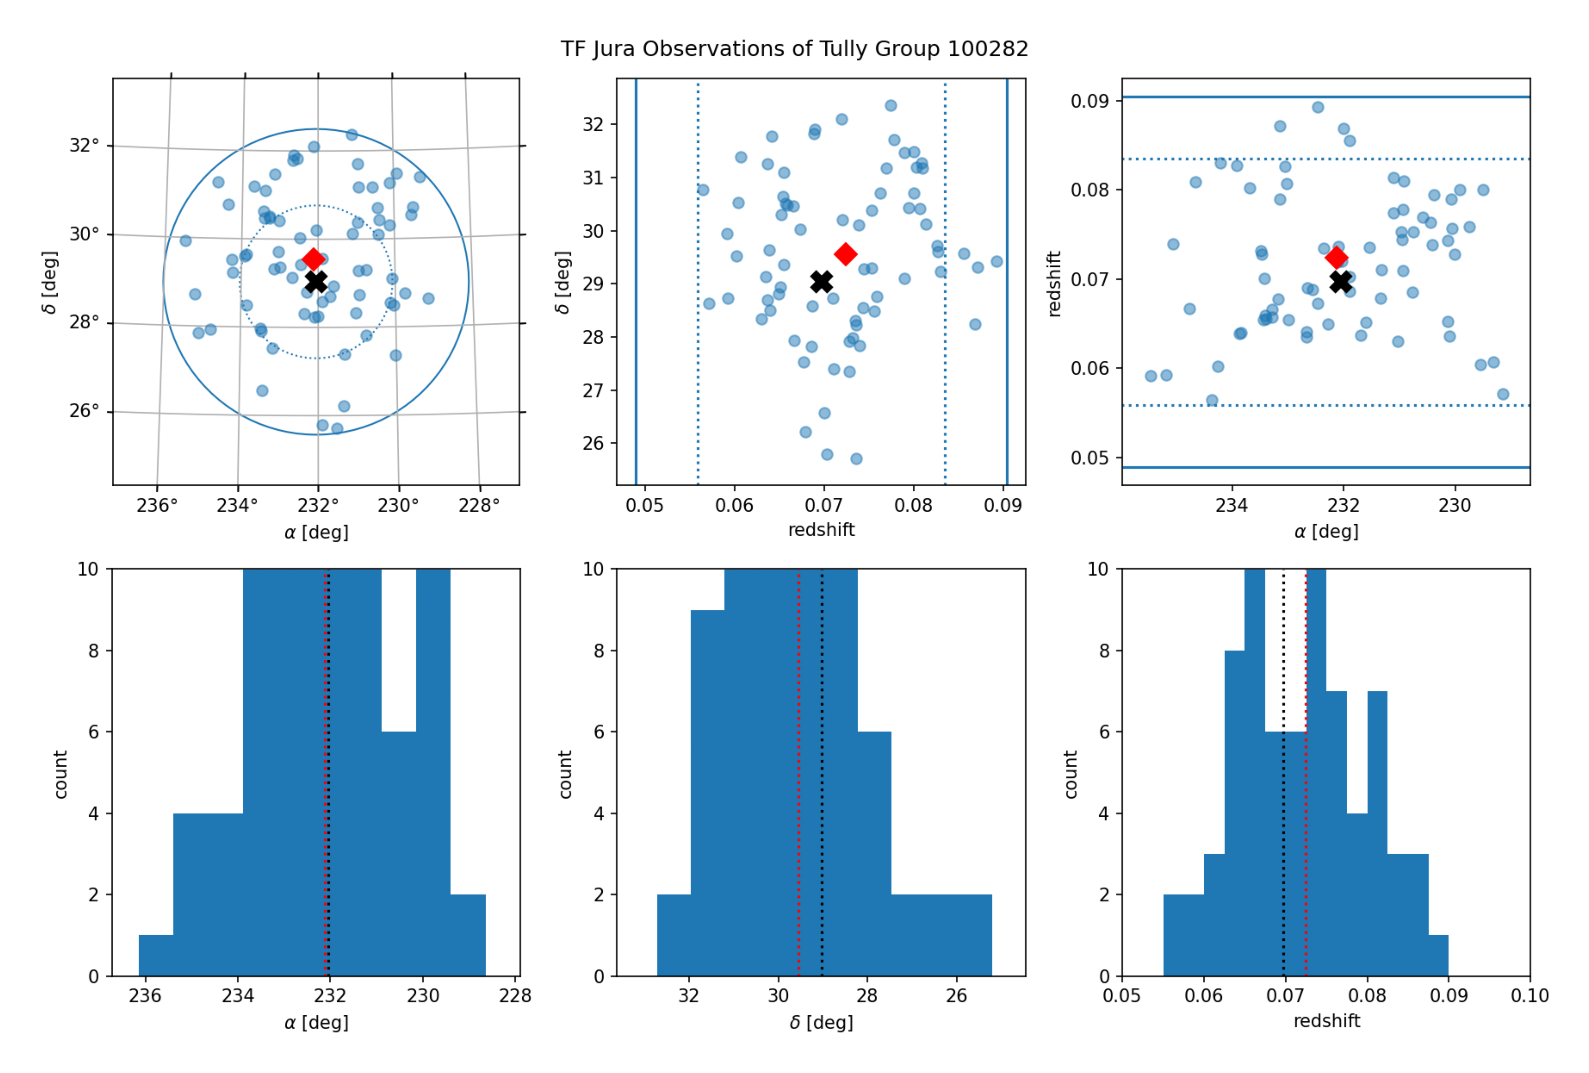

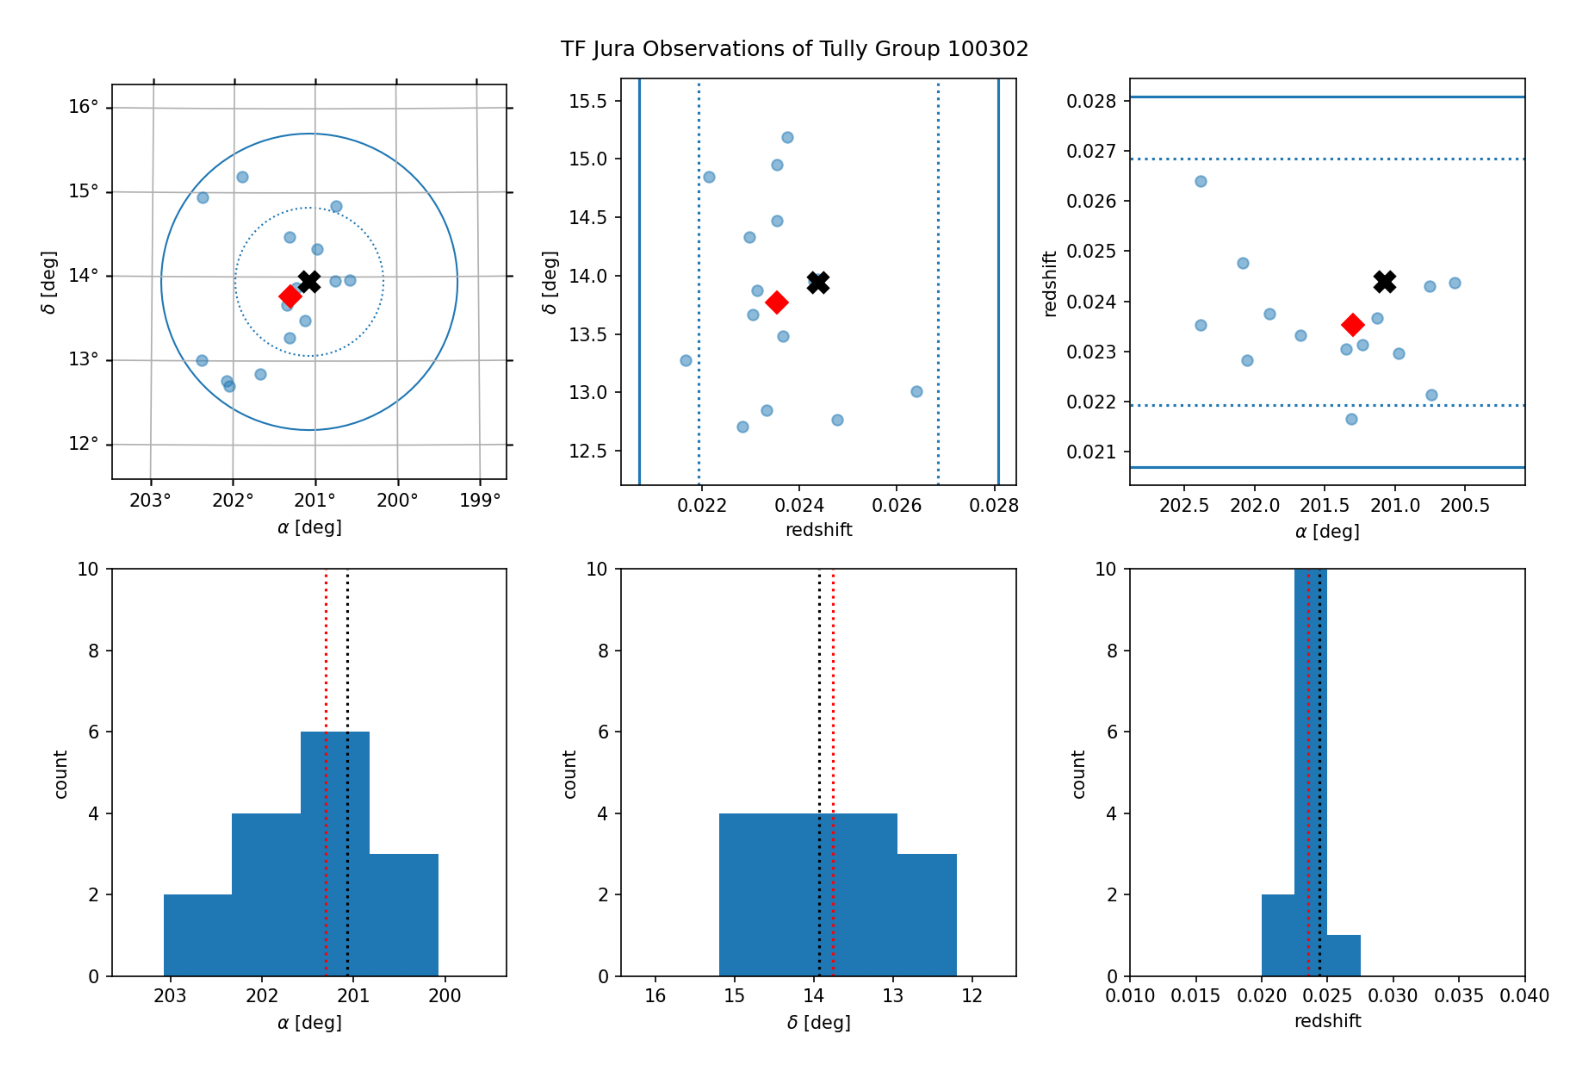

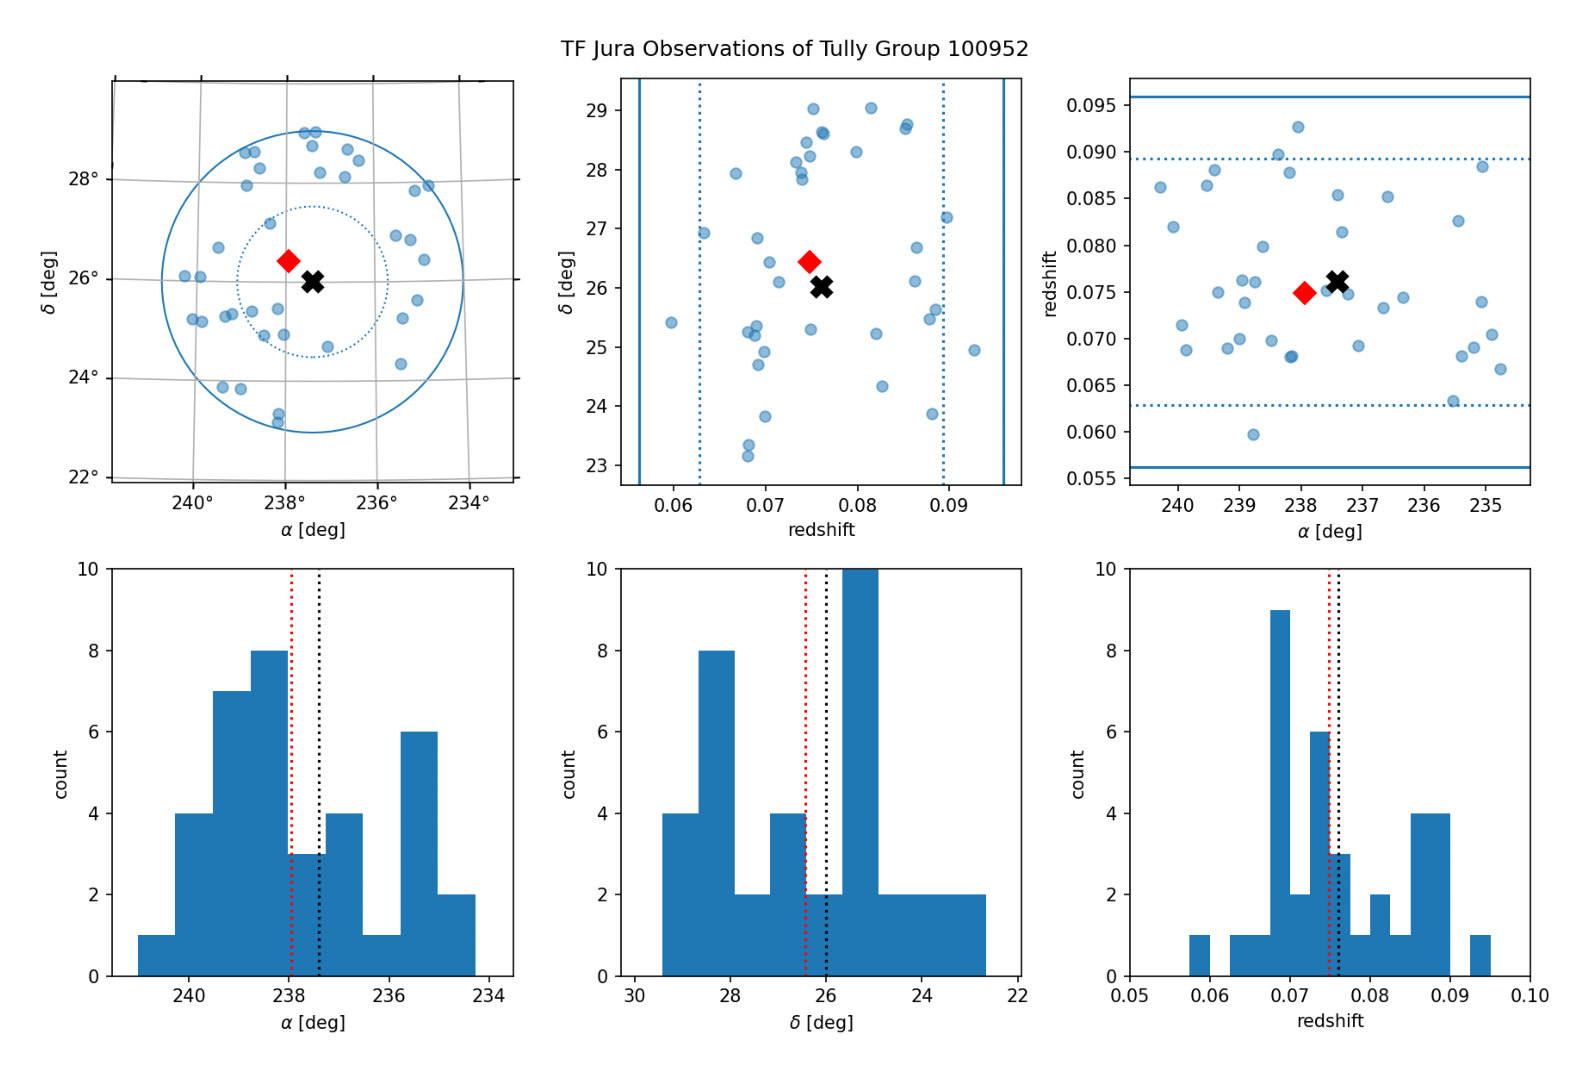

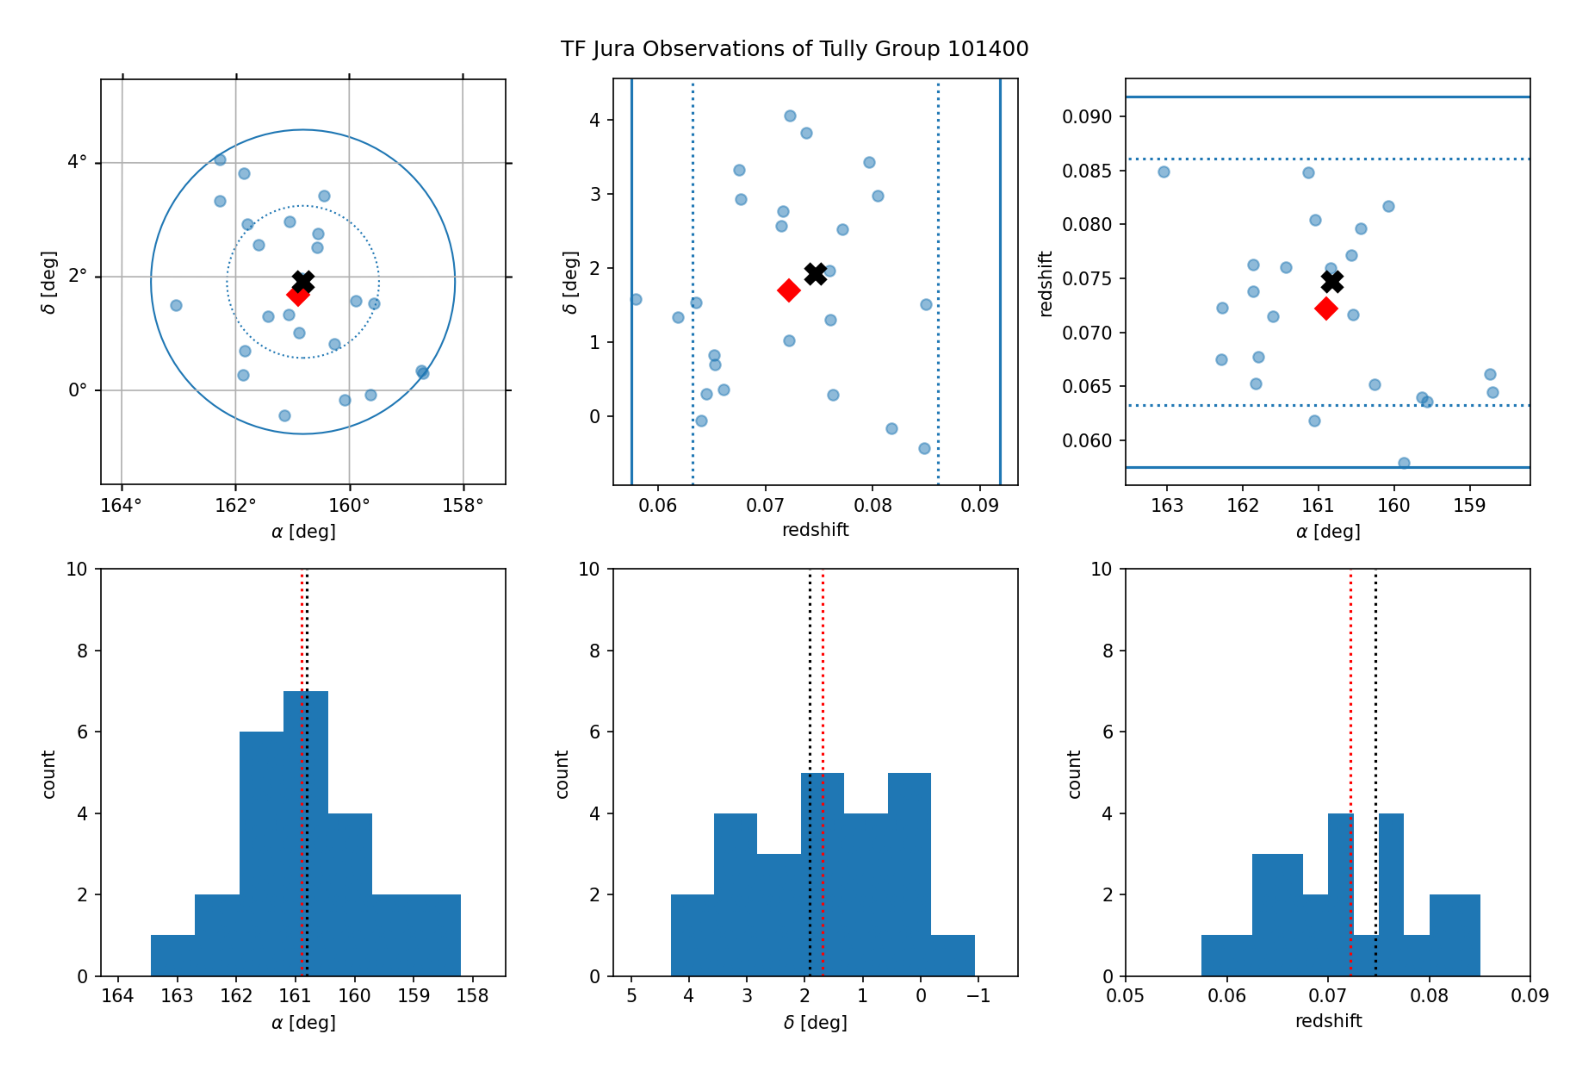

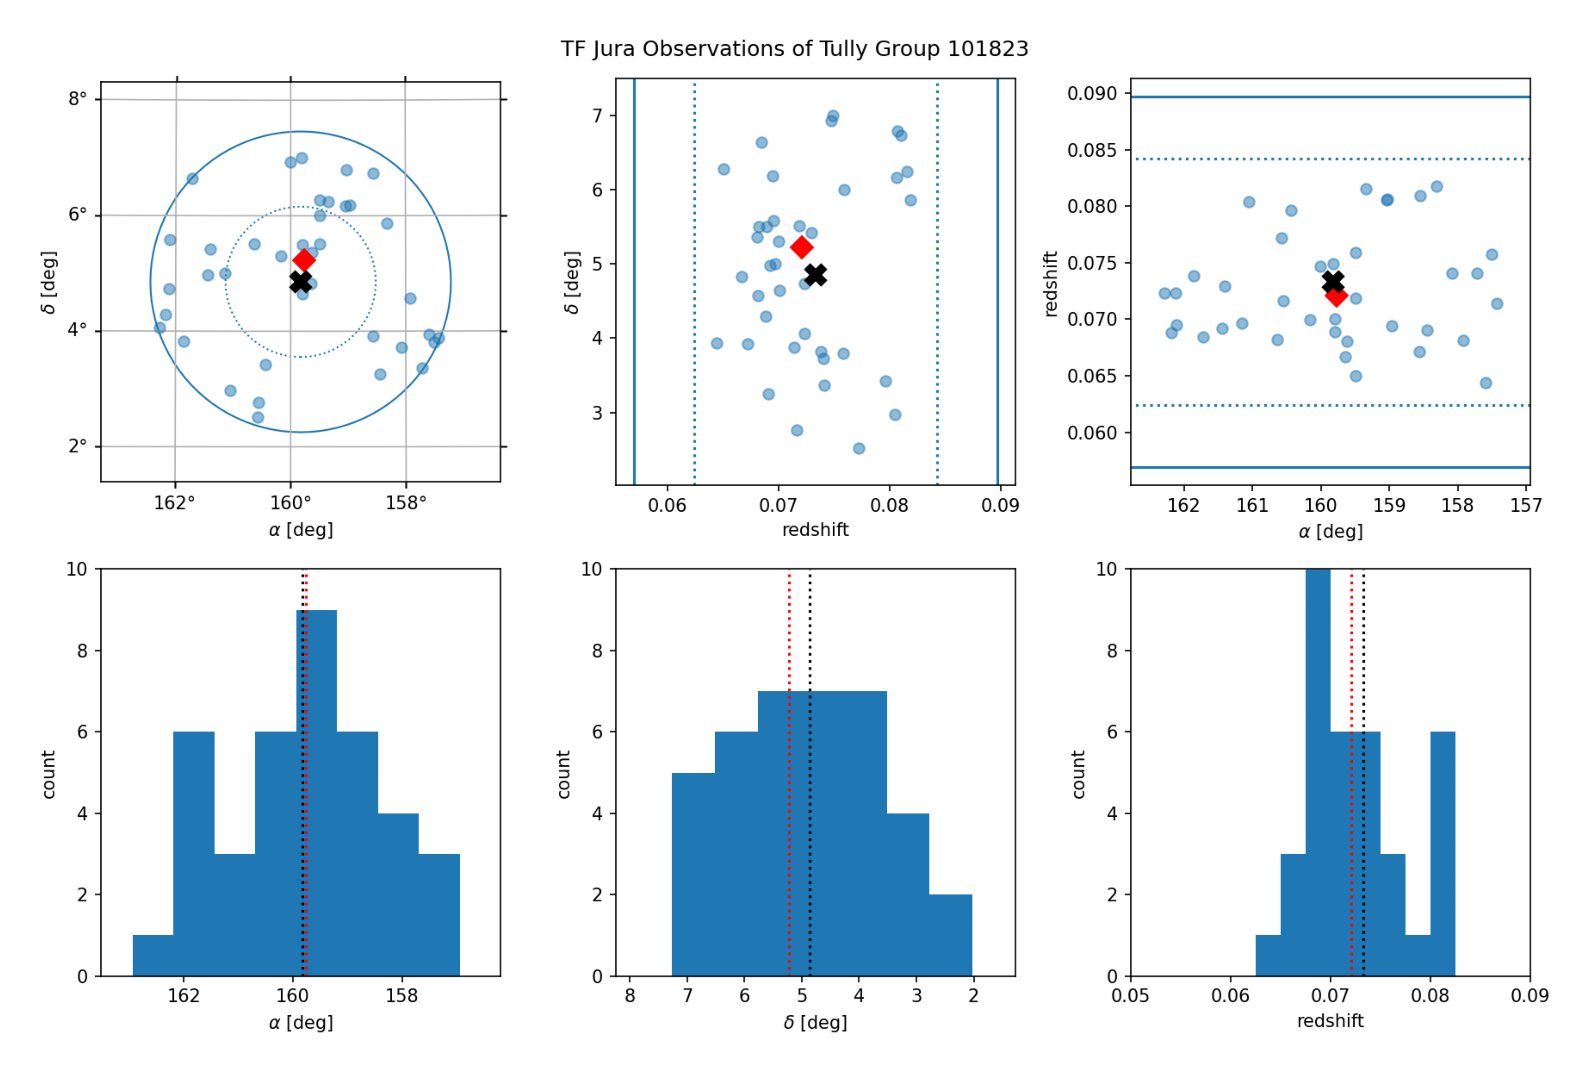

In [58]:
##### Show the galaxy clusters that contain multiple galaxies

import matplotlib.image

for i in cluster_probs:
    plt.figure(figsize=(10, 10), dpi=200)
    img = matplotlib.image.imread('Figures/TF_Y3_cluster_{}_accept.png'.format(i))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [59]:
clusters = Table.read('../Tully15-Table3.fits')
clusters

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
,,,,deg,deg,[Lsun],km / s,mag,km / s,Mpc,km / s,Msun,
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1.710e+15,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.440,707,5.290e+14,1.00
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.520,746,6.230e+14,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1.770e+15,2.26
1,100005,61,36487,92.0255,-10.4950,12.78,6987,34.22,707,1.560,766,6.730e+14,1.58
1,100006,85,31478,139.4478,-37.6063,12.48,4099,33.06,648,1.198,588,3.050e+14,1.14
1,100007,86,56962,108.5182,49.0878,13.52,11603,35.32,1261,2.821,1385,3.980e+15,3.30
1,100008,65,39600,67.2953,3.2390,11.94,1054,30.11,209,0.745,366,7.330e+13,1.00


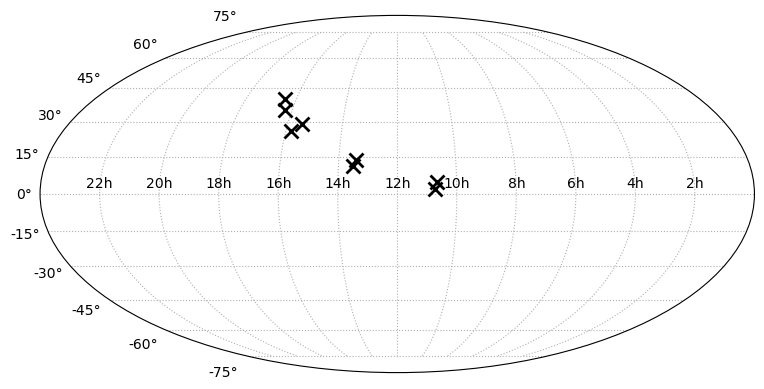

In [60]:
##### Plot where these clusters fall on the map


# nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.in1d(clusters['Nest'], cluster_probs)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=2)
    

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('Figures/TF_Y3_SGA_Vrot_clusters.png', dpi=150);

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# from astropy.coordinates import SkyCoord
# import astropy.units as u

# # Assuming 'clusters' is an Astropy Table and 'cluster_probs' is a list/array of probabilities
# idx = np.in1d(clusters['Nest'], cluster_probs)  # Index of clusters matching the 'cluster_probs'

# # Extracting the corresponding longitude, latitude, and cluster probabilities
# cluster_lon = clusters['SGLON'][idx]
# cluster_lat = clusters['SGLAT'][idx]
# cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')
# cluster_prob_values = cluster_probs[idx]  # Cluster probabilities corresponding to selected clusters

# # Plotting setup
# fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, subplot_kw={'projection': 'mollweide'})

# # Loop through each coordinate to plot and annotate
# for coord, prob in zip(cluster_coords, cluster_prob_values):
#     # Convert to ICRS coordinates for plotting
#     _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
#     _dec = np.radians(coord.transform_to('icrs').dec)
    
#     # Plot the point (cluster)
#     ax.plot(_ra, _dec, 'kx', ms=10, mew=2)
    
#     # Annotate with cluster probability
#     ax.text(_ra, _dec, f'{prob:.2f}', color='red', ha='left', va='bottom', fontsize=9)

# # Customize axes and grid
# ax.set(xticklabels=[f'{_}h' for _ in np.arange(2, 24, 2)][::-1])
# ax.grid(ls=':')

# # Show plot
# plt.show()


array([False, False, False, ..., False, False, False])

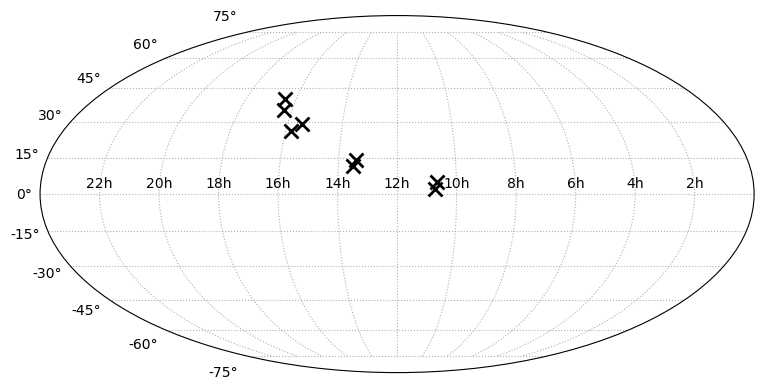

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

# Step 1: Use np.in1d to find matching 'Nest' IDs between clusters and problematic clusters
matching_idx = np.in1d(clusters['Nest'], cluster_probs)  # boolean array for matching 'Nest' IDs

# Step 2: Filter the clusters that match the 'Nest' IDs in cluster_probs
matching_clusters = clusters[matching_idx]  # Subset of clusters that match problematic 'Nest' IDs

# Step 3: Get coordinates (longitude and latitude) of matching clusters
cluster_lon = matching_clusters['SGLON']
cluster_lat = matching_clusters['SGLAT']
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

# Step 4: Plotting setup
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, subplot_kw={'projection': 'mollweide'})

# Step 5: Loop through each matching coordinate, plot it, and annotate with the index in cluster_probs
for i, (coord) in enumerate(cluster_coords):
    # Convert to ICRS coordinates for plotting
    ra = coord.transform_to('icrs').ra  # Right Ascension
    dec = coord.transform_to('icrs').dec  # Declination
    
    # Convert from SkyCoord to radians for plotting
    _ra = np.radians(180*u.deg - ra).value  # Convert RA to radians and strip off units
    _dec = np.radians(dec).value  # Convert Dec to radians and strip off units
    
    # Plot the point (cluster) as a cross ('kx')
    ax.plot(_ra, _dec, 'kx', ms=10, mew=2)
    
    # Annotate with index from cluster_probs
    # label = f"{cluster_probs[i]:02d}"[-2:]  # Add the index from cluster_probs as the label
    # ax.text(_ra, _dec, color='blue', ha='left', va='bottom', fontsize=12)

# Step 6: Customize axes and grid for better readability
ax.set(xticklabels=[f'{_}h' for _ in np.arange(2, 24, 2)][::-1])
ax.grid(ls=':')

# Show plot
plt.show()


In [62]:
# Step 1: Create a dictionary to hold the cluster overlaps
cluster_overlap = {}

# Step 2: Loop over the rows of the table and collect all clusters a galaxy is in
for galaxy_id in np.unique(SGA['SGA_ID']):
    # Get the indices of the rows that belong to this galaxy
    galaxy_rows =SGA[SGA['SGA_ID'] == galaxy_id]
    
    # Get the list of clusters this galaxy belongs to
    clusters = galaxy_rows['CLUSTER_ID']
    
    # For each cluster, add the others this galaxy is in to the overlap dictionary
    for cluster in clusters:
        if cluster not in cluster_overlap:
            cluster_overlap[cluster] = set()
        
        # Add the other clusters that this galaxy belongs to (excluding the current cluster)
        cluster_overlap[cluster].update([c for c in clusters if c != cluster])

# Step 3: Print the results
for cluster_id, overlaps in cluster_overlap.items():
    print(f"Cluster {cluster_id} overlaps with clusters: {sorted(list(overlaps))}")


Cluster 100081 overlaps with clusters: []
Cluster 103171 overlaps with clusters: []
Cluster 100526 overlaps with clusters: [100617]
Cluster 100004 overlaps with clusters: [100041]
Cluster 103229 overlaps with clusters: []
Cluster 103257 overlaps with clusters: []
Cluster 100002 overlaps with clusters: []
Cluster 103172 overlaps with clusters: []
Cluster 100046 overlaps with clusters: [100067]
Cluster 100617 overlaps with clusters: [100526]
Cluster 103283 overlaps with clusters: []
Cluster 100007 overlaps with clusters: []
Cluster 100952 overlaps with clusters: [100282]
Cluster 100125 overlaps with clusters: []
Cluster 101823 overlaps with clusters: [101400]
Cluster 103224 overlaps with clusters: []
Cluster 100067 overlaps with clusters: [100046]
Cluster 100041 overlaps with clusters: [100004]
Cluster 100049 overlaps with clusters: [100302]
Cluster 100077 overlaps with clusters: []
Cluster 100282 overlaps with clusters: [100952]
Cluster 103182 overlaps with clusters: []
Cluster 101732 o

In [63]:
# Step 1: Create a dictionary to hold the cluster overlaps
cluster_overlap = {}

# Step 2: Loop over the rows of the table and collect all clusters a galaxy is in
for galaxy_id in np.unique(duplicates['SGA_ID']):
    # Get the indices of the rows that belong to this galaxy
    galaxy_rows =duplicates[duplicates['SGA_ID'] == galaxy_id]
    
    # Get the list of clusters this galaxy belongs to
    clusters = galaxy_rows['CLUSTER_ID']
    
    # For each cluster, add the others this galaxy is in to the overlap dictionary
    for cluster in clusters:
        if cluster not in cluster_overlap:
            cluster_overlap[cluster] = set()
        
        # Add the other clusters that this galaxy belongs to (excluding the current cluster)
        cluster_overlap[cluster].update([c for c in clusters if c != cluster])

# Step 3: Print the results
for cluster_id, overlaps in cluster_overlap.items():
    print(f"Cluster {cluster_id} overlaps with clusters: {sorted(list(overlaps))}")


Cluster 100046 overlaps with clusters: [100067]
Cluster 100067 overlaps with clusters: [100046]
Cluster 100302 overlaps with clusters: [100049]
Cluster 100049 overlaps with clusters: [100302]
Cluster 100952 overlaps with clusters: [100282]
Cluster 100282 overlaps with clusters: [100952]
Cluster 101400 overlaps with clusters: [101823]
Cluster 101823 overlaps with clusters: [101400]
Cluster 100004 overlaps with clusters: [100041]
Cluster 100041 overlaps with clusters: [100004]
Cluster 100526 overlaps with clusters: [100617]
Cluster 100617 overlaps with clusters: [100526]


In [64]:

# Step 1: Create a dictionary to hold the clusters and their galaxies
cluster_galaxies = {}

# Step 2: Populate the cluster_galaxies dictionary with sets of galaxies for each cluster
for i, row in enumerate(duplicates):
    cluster_id = row['CLUSTER_ID']
    galaxy_id = row['SGA_ID']
    
    # Initialize the set for the cluster if it doesn't exist
    if cluster_id not in cluster_galaxies:
        cluster_galaxies[cluster_id] = set()
    
    # Add the galaxy to the set of the corresponding cluster
    cluster_galaxies[cluster_id].add(galaxy_id)

# Step 3: Create a dictionary to store the count of overlapping galaxies between clusters
cluster_pair_counts = {}

# Step 4: Compare each pair of clusters to find overlaps
for cluster1, galaxies1 in cluster_galaxies.items():
    for cluster2, galaxies2 in cluster_galaxies.items():
        if cluster1 < cluster2:  # Avoid double counting pairs (cluster1, cluster2) and (cluster2, cluster1)
            # Find the intersection of galaxies in both clusters
            overlapping_galaxies = galaxies1.intersection(galaxies2)
            
            # Store the count of overlapping galaxies
            cluster_pair_counts[(cluster1, cluster2)] = len(overlapping_galaxies)

# Step 5: Print the results
for cluster_pair, count in cluster_pair_counts.items():
    cluster1, cluster2 = cluster_pair
    if count > 0:
        print(cluster1,',',cluster2, ',')



100046 , 100067 ,
100049 , 100302 ,
100282 , 100952 ,
101400 , 101823 ,
100004 , 100041 ,
100526 , 100617 ,


In [65]:
def plot_cluster_members(clusters, cluster_id1, cluster_id2, sgacat, sga_ids1, sga_ids2, H0=70, c_kms=3e5):
    """Generate a set of diagnostic plots for the members of two clusters."""
    
    # Ensure correct data types for comparison
    cluster_id1 = int(cluster_id1)
    cluster_id2 = int(cluster_id2)
    
    clusters['Nest'] = clusters['Nest'].astype(int)
    sgacat['SGA_ID'] = sgacat['SGA_ID'].astype(int)
    
    # Get cluster 1 sky coordinates
    idx1 = np.in1d(clusters['Nest'], [cluster_id1])  # Ensure 'cluster_id1' is passed as a list
    cluster_lon1 = clusters['SGLON'][idx1][0]
    cluster_lat1 = clusters['SGLAT'][idx1][0]
    cluster_mu1 = clusters['DM'][idx1][0]
    cluster_dist1 = 10 * 10**(0.2*cluster_mu1) * 1e-6
    cluster_v1 = H0 * cluster_dist1
    cluster_sigma1 = clusters['sigP'][idx1][0]
    cluster_R2t1 = clusters['R2t'][idx1][0]
    cluster_R2t_1p5_1 = np.arctan(1.5 * cluster_R2t1 / (cluster_v1 / H0)) * u.radian
    cluster_R2t_3_1 = np.arctan(3 * cluster_R2t1 / (cluster_v1 / H0)) * u.radian
    cluster_R2t_4_1 = np.arctan(4 * cluster_R2t1 / (cluster_v1 / H0)) * u.radian
    cluster_coord1 = SkyCoord(cluster_lon1, cluster_lat1, unit='deg', frame='supergalactic').transform_to('icrs')
    
    # Get cluster 2 sky coordinates
    idx2 = np.in1d(clusters['Nest'], [cluster_id2])  # Same for cluster_id2
    cluster_lon2 = clusters['SGLON'][idx2][0]
    cluster_lat2 = clusters['SGLAT'][idx2][0]
    cluster_mu2 = clusters['DM'][idx2][0]
    cluster_dist2 = 10 * 10**(0.2*cluster_mu2) * 1e-6
    cluster_v2 = H0 * cluster_dist2
    cluster_sigma2 = clusters['sigP'][idx2][0]
    cluster_R2t2 = clusters['R2t'][idx2][0]
    cluster_R2t_1p5_2 = np.arctan(1.5 * cluster_R2t2 / (cluster_v2 / H0)) * u.radian
    cluster_R2t_3_2 = np.arctan(3 * cluster_R2t2 / (cluster_v2 / H0)) * u.radian
    cluster_R2t_4_2 = np.arctan(4 * cluster_R2t2 / (cluster_v2 / H0)) * u.radian
    cluster_coord2 = SkyCoord(cluster_lon2, cluster_lat2, unit='deg', frame='supergalactic').transform_to('icrs')

    # Print cluster info
    print(f"Cluster 1 coordinates: {cluster_coord1}")
    print(f"Cluster 2 coordinates: {cluster_coord2}")
    print(f"Cluster 1 velocity: {cluster_v1} +/- {cluster_sigma1} km/s")
    print(f"Cluster 2 velocity: {cluster_v2} +/- {cluster_sigma2} km/s")
    
    # Handle SGA galaxies for both clusters
    sga_ids1 = np.array(sga_ids1, dtype=int)
    sga_ids2 = np.array(sga_ids2, dtype=int)
    
    idx1_sga = np.in1d(sgacat['SGA_ID'], sga_ids1)
    idx2_sga = np.in1d(sgacat['SGA_ID'], sga_ids2)
    
    # (Continue the rest of your plotting logic here...)


In [67]:
SGA = Table.read('SGA-2020_jura_Vrot_cluster_calib_VI.fits')
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,MORPHTYPE_AI,CLUSTER_ID
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes10,int32
2056,SGA-2020 2056,PGC3090638,3090638,193.6930065,15.5916891,I,3.24,0.42953643,0.76736146,0.008800754,23.633482,16.84,False,LEDA-20181114,585,PGC3090638,1,True,193.6930065,15.5916891,0.42953643,1935p155,193.69299749312026,15.591724570040274,0.48851982,SB26,11.668644,0.71603954,193.69289191559892,15.591839847613839,11.774455,4.3058023,4.495752,4.616412,4.9170485,6.18269,7.3138824,8.316136,9.319301,10.374897,11.635473,13.073705,14.655595,17.134708,16.869791,16.704203,16.90455,16.627546,16.45877,16.776154,16.492624,16.320917,16.705257,16.416267,16.241508,16.658772,16.36552,16.185635,16.627045,16.330387,16.145723,16.600666,16.302883,16.113653,16.582727,16.281683,16.092112,16.56931,16.263586,16.071106,0.024651717,0.025509562,0.021021688,0.025019383,0.03921681,0.056336682,0.063054726,0.08825987,0.12649716,0.015854347,0.013339996,0.011880502,0.013634203,0.011504582,0.010417499,0.01244435,0.010522052,0.009550867,0.011776679,0.009949894,0.009043998,0.011338439,0.009571019,0.00871683,0.011039947,0.009308954,0.008486015,0.010776741,0.00910255,0.008319424,0.010626387,0.008958327,0.008239374,0.010505741,0.008833059,0.008163062,16.543903,0.44915918,0.22805132,3.4967303,0.036943246,16.231367,0.540412,0.22578783,3.2461774,0.15273538,16.030418,0.5509384,0.26220718,3.1179378,0.12921499,0,0.008823219284795633,7.259279427755243e-07,34.20494444899026,1.0197240309578985,Spiral,100002

In [68]:
clusters = Table.read('../Tully15-Table3.fits')
clusters

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
,,,,deg,deg,[Lsun],km / s,mag,km / s,Mpc,km / s,Msun,
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1.710e+15,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.440,707,5.290e+14,1.00
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.520,746,6.230e+14,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1.770e+15,2.26
1,100005,61,36487,92.0255,-10.4950,12.78,6987,34.22,707,1.560,766,6.730e+14,1.58
1,100006,85,31478,139.4478,-37.6063,12.48,4099,33.06,648,1.198,588,3.050e+14,1.14
1,100007,86,56962,108.5182,49.0878,13.52,11603,35.32,1261,2.821,1385,3.980e+15,3.30
1,100008,65,39600,67.2953,3.2390,11.94,1054,30.11,209,0.745,366,7.330e+13,1.00


In [20]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [137]:
sga_1 = SGA[SGA['CLUSTER_ID']==100004]
sga_2 = SGA[SGA['CLUSTER_ID']==100110]

{761,
 11814,
 13048,
 35282,
 99148,
 126873,
 182887,
 206411,
 216568,
 363534,
 376525,
 453159,
 557735,
 565828,
 618981,
 782432,
 997295,
 1010326,
 1081088,
 1183861,
 1206016,
 1208245}

In [69]:
def plot_double_cluster_members(clusters, cluster_id_1, cluster_id_2, sgacat, sga_ids1, sga_ids2):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx_1 = np.in1d(clusters['Nest'], cluster_id_1)
    cluster_lon_1 = clusters['SGLON'][idx_1][0]
    cluster_lat_1 = clusters['SGLAT'][idx_1][0]
    cluster_mu_1 = clusters['DM'][idx_1][0]
    cluster_dist_1 = 10 * 10**(0.2*cluster_mu_1) * 1e-6
    cluster_v_1 = H0*cluster_dist_1
    cluster_sigma_1 = clusters['sigP'][idx_1][0]
    cluster_R2t_1 = clusters['R2t'][idx_1][0]
    cluster_R2t_1p5_1 = np.arctan(1.5*cluster_R2t_1 / (cluster_v_1/H0)) * u.radian
    cluster_R2t_3_1 = np.arctan(3*cluster_R2t_1 / (cluster_v_1/H0)) * u.radian
    cluster_R2t_4_1 = np.arctan(4*cluster_R2t_1 / (cluster_v_1/H0)) * u.radian
    
    idx_2 = np.in1d(clusters['Nest'], cluster_id_2)
    cluster_lon_2 = clusters['SGLON'][idx_2][0]
    cluster_lat_2 = clusters['SGLAT'][idx_2][0]
    cluster_mu_2 = clusters['DM'][idx_2][0]
    cluster_dist_2 = 10 * 10**(0.2*cluster_mu_2) * 1e-6
    cluster_v_2 = H0*cluster_dist_2
    cluster_sigma_2 = clusters['sigP'][idx_2][0]
    cluster_R2t_2 = clusters['R2t'][idx_2][0]
    cluster_R2t_1p5_2 = np.arctan(1.5*cluster_R2t_2 / (cluster_v_2/H0)) * u.radian
    cluster_R2t_3_2 = np.arctan(3*cluster_R2t_2 / (cluster_v_2/H0)) * u.radian
    cluster_R2t_4_2 = np.arctan(4*cluster_R2t_2 / (cluster_v_2/H0)) * u.radian
    
    
    cluster_coord_1 = SkyCoord(cluster_lon_1, cluster_lat_1, unit='deg', frame='supergalactic').transform_to('icrs')
    cluster_coord_2 = SkyCoord(cluster_lon_2, cluster_lat_2, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord_1)
    print(f'{cluster_v_1} +/- {cluster_sigma_1} km/s')
    
    print(cluster_coord_2)
    print(f'{cluster_v_2} +/- {cluster_sigma_2} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx_1 = np.in1d(sgacat['SGA_ID'], sga_ids1)
    z_sga_1 = sgacat['Z_DESI'][idx_1]
    z_sorted_1 = np.sort(z_sga_1)
    ngal_1 = len(z_sorted_1)
    z_sga_median_1 = np.mean(z_sorted_1[ngal_1//2:ngal_1//2 + 2]) if (ngal_1 % 2 == 0) else z_sorted_1[ngal_1//2]
    
    sga_coords_1 = SkyCoord(ra=sgacat['RA'][idx_1], dec=sgacat['DEC'][idx_1], unit='deg', frame='icrs')
    sga_coords_median_1 = cluster_median_coords(sga_coords_1)

    idx_2 = np.in1d(sgacat['SGA_ID'], sga_ids2)
    z_sga_2 = sgacat['Z_DESI'][idx_2]
    z_sorted_2 = np.sort(z_sga_2)
    ngal_2 = len(z_sorted_2)
    z_sga_median_2 = np.mean(z_sorted_2[ngal_2//2:ngal_2//2 + 2]) if (ngal_2 % 2 == 0) else z_sorted_2[ngal_2//2]
    
    sga_coords_2 = SkyCoord(ra=sgacat['RA'][idx_2], dec=sgacat['DEC'][idx_2], unit='deg', frame='icrs')
    sga_coords_median_2 = cluster_median_coords(sga_coords_2)
    
    
    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord_1, radius=cluster_R2t_4_1+cluster_R2t_4_2)
    ax.grid()

    ax.plot(sga_coords_1.ra.deg, sga_coords_1.dec.deg, 'bo', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median_1.ra.deg, sga_coords_median_1.dec.deg, 'bD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_1.ra.deg, cluster_coord_1.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)
    
    ax.plot(sga_coords_2.ra.deg, sga_coords_2.dec.deg, 'ro', transform=ax.get_transform('world'), alpha=0.3, label=f'{cluster_id}')
    ax.plot(sga_coords_median_2.ra.deg, sga_coords_median_2.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_2.ra.deg, cluster_coord_2.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)
    
    # ax.plot(sga_coords_3.ra.deg, sga_coords_3.dec.deg, 'go', transform=ax.get_transform('world'), alpha=0.5)
    
    inner_1 = SphericalCircle(cluster_coord_1, cluster_R2t_1p5_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_1)

    outer_1 = SphericalCircle(cluster_coord_1, cluster_R2t_3_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer_1)    
    

    inner_2 = SphericalCircle(cluster_coord_2, cluster_R2t_1p5_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_2)

    outer_2 = SphericalCircle(cluster_coord_2, cluster_R2t_3_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='solid', facecolor='none')
    ax.add_patch(outer_2)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    
    ax.plot(z_sga_1, sga_coords_1.dec.deg, 'bo', alpha=0.5, label=f'{cluster_id}')
    ax.plot(z_sga_median_1, sga_coords_median_1.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v_1/c_kms, cluster_coord_1.dec.deg, 'kx', ms=10, mew=5)

    decmin_1 = np.min(sga_coords_1.dec.deg) - 0.5
    decmax_1 = np.max(sga_coords_1.dec.deg) + 0.5
    
    ax.plot(z_sga_2, sga_coords_2.dec.deg, 'ro', alpha=0.3, label=f'{cluster_id}')
    ax.plot(z_sga_median_2, sga_coords_median_2.dec.deg, 'rD', ms=5, mew=5)
    ax.plot(cluster_v_2/c_kms, cluster_coord_2.dec.deg, 'kx', ms=10, mew=5)

    decmin_2 = np.min(sga_coords_2.dec.deg) - 0.5
    decmax_2 = np.max(sga_coords_2.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v_1-3*cluster_sigma_1,
                          cluster_v_1+3*cluster_sigma_1,
                          cluster_v_1-2*cluster_sigma_1,
                          cluster_v_1+2*cluster_sigma_1,])/c_kms,
                          decmin_1, decmax_1,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])    

    
    ax.vlines(np.asarray([cluster_v_2-3*cluster_sigma_2,
                          cluster_v_2+3*cluster_sigma_2,
                          cluster_v_2-2*cluster_sigma_2,
                          cluster_v_2+2*cluster_sigma_2])/c_kms,
                          decmin_2, decmax_2,
              colors='tab:red',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])      
    
    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(min(decmin_1, decmin_2), max(decmax_1,decmax_2)))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(sga_coords_1.ra.deg, z_sga_1, 'bo', alpha=0.5, label=f'{cluster_id}')
    ax.plot(sga_coords_median_1.ra.deg, z_sga_median_1, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord_1.ra.deg, cluster_v_1/c_kms, 'kx', ms=10, mew=5)

    ramin_1 = np.min(sga_coords_1.ra.deg) - 0.5
    ramax_1 = np.max(sga_coords_1.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v_1-3*cluster_sigma_1,
                          cluster_v_1+3*cluster_sigma_1,
                          cluster_v_1-2*cluster_sigma_1,
                          cluster_v_1+2*cluster_sigma_1])/c_kms,
              ramin_1, ramax_1,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.plot(sga_coords_2.ra.deg, z_sga_2, 'ro', alpha=0.3, label=f'{cluster_id}')
    ax.plot(sga_coords_median_2.ra.deg, z_sga_median_2, 'rD', ms=5, mew=5)
    ax.plot(cluster_coord_2.ra.deg, cluster_v_2/c_kms, 'kx', ms=10, mew=5)

    ramin_2 = np.min(sga_coords_2.ra.deg) - 0.5
    ramax_2 = np.max(sga_coords_2.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v_2-3*cluster_sigma_2,
                          cluster_v_2+3*cluster_sigma_2,
                          cluster_v_2-2*cluster_sigma_2,
                          cluster_v_2+2*cluster_sigma_2])/c_kms,
              ramin_2, ramax_2,
              colors='tab:red',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])    
    
    
    
    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(max(ramax_1, ramax_2), min(ramin_1,ramin_2)))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    fig.suptitle(f'TF Jura Observations of Clusters {cluster_id_1} and {cluster_id_2}')

    return fig

In [49]:
def plot_triple_cluster_members(clusters, cluster_id_1, cluster_id_2, cluster_id_3, sgacat, sga_ids1, sga_ids2, sga_ids3):
    """Generate a set of diagnostic plots for the members of three clusters."""
    
    #- Get cluster sky coordinates and properties for cluster 1, 2, and 3
    def get_cluster_properties(cluster_id):
        idx = np.in1d(clusters['Nest'], cluster_id)
        cluster_lon = clusters['SGLON'][idx][0]
        cluster_lat = clusters['SGLAT'][idx][0]
        cluster_mu = clusters['DM'][idx][0]
        cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
        cluster_v = H0 * cluster_dist
        cluster_sigma = clusters['sigP'][idx][0]
        cluster_R2t = clusters['R2t'][idx][0]
        cluster_R2t_1p5 = np.arctan(1.5 * cluster_R2t / (cluster_v / H0)) * u.radian
        cluster_R2t_3 = np.arctan(3 * cluster_R2t / (cluster_v / H0)) * u.radian
        cluster_R2t_4 = np.arctan(4 * cluster_R2t / (cluster_v / H0)) * u.radian
        return cluster_lon, cluster_lat, cluster_mu, cluster_v, cluster_sigma, cluster_R2t, cluster_R2t_1p5, cluster_R2t_3, cluster_R2t_4

    # Get properties for all three clusters
    cluster_data_1 = get_cluster_properties(cluster_id_1)
    cluster_data_2 = get_cluster_properties(cluster_id_2)
    cluster_data_3 = get_cluster_properties(cluster_id_3)
    
    # Unpack the cluster data
    cluster_lon_1, cluster_lat_1, cluster_mu_1, cluster_v_1, cluster_sigma_1, cluster_R2t_1, cluster_R2t_1p5_1, cluster_R2t_3_1, cluster_R2t_4_1 = cluster_data_1
    cluster_lon_2, cluster_lat_2, cluster_mu_2, cluster_v_2, cluster_sigma_2, cluster_R2t_2, cluster_R2t_1p5_2, cluster_R2t_3_2, cluster_R2t_4_2 = cluster_data_2
    cluster_lon_3, cluster_lat_3, cluster_mu_3, cluster_v_3, cluster_sigma_3, cluster_R2t_3, cluster_R2t_1p5_3, cluster_R2t_3_3, cluster_R2t_4_3 = cluster_data_3
    
    # Get cluster sky coordinates (ICRS frame)
    cluster_coord_1 = SkyCoord(cluster_lon_1, cluster_lat_1, unit='deg', frame='supergalactic').transform_to('icrs')
    cluster_coord_2 = SkyCoord(cluster_lon_2, cluster_lat_2, unit='deg', frame='supergalactic').transform_to('icrs')
    cluster_coord_3 = SkyCoord(cluster_lon_3, cluster_lat_3, unit='deg', frame='supergalactic').transform_to('icrs')

    # Get SGA galaxy coordinates and median redshift for each cluster
    def get_sga_coords_and_median_redshift(sga_ids):
        idx = np.in1d(sgacat['SGA_ID'], sga_ids)
        z_sga = sgacat['Z_DESI'][idx]
        z_sorted = np.sort(z_sga)
        ngal = len(z_sorted)
        z_median = np.mean(z_sorted[ngal // 2: ngal // 2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal // 2]
        sga_coords = SkyCoord(ra=sgacat['RA'][idx], dec=sgacat['DEC'][idx], unit='deg', frame='icrs')
        sga_coords_median = cluster_median_coords(sga_coords)
        return z_sga, sga_coords, sga_coords_median, z_median
    
    z_sga_1, sga_coords_1, sga_coords_median_1, z_sga_median_1 = get_sga_coords_and_median_redshift(sga_ids1)
    z_sga_2, sga_coords_2, sga_coords_median_2, z_sga_median_2 = get_sga_coords_and_median_redshift(sga_ids2)
    z_sga_3, sga_coords_3, sga_coords_median_3, z_sga_median_3 = get_sga_coords_and_median_redshift(sga_ids3)
    
    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(15,10), tight_layout=True)
    
    # First plot: Cluster sky coordinates
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord_1, radius=cluster_R2t_4_1 + cluster_R2t_4_2 + cluster_R2t_4_3)
    ax.grid()

    # Cluster 1 (blue), Cluster 2 (red), Cluster 3 (green)
    ax.plot(sga_coords_1.ra.deg, sga_coords_1.dec.deg, 'bo', transform=ax.get_transform('world'), alpha=0.5, label=f'Cluster {cluster_id_1}')
    ax.plot(sga_coords_median_1.ra.deg, sga_coords_median_1.dec.deg, 'bD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_1.ra.deg, cluster_coord_1.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    ax.plot(sga_coords_2.ra.deg, sga_coords_2.dec.deg, 'ro', transform=ax.get_transform('world'), alpha=0.3, label=f'Cluster {cluster_id_2}')
    ax.plot(sga_coords_median_2.ra.deg, sga_coords_median_2.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_2.ra.deg, cluster_coord_2.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)

    ax.plot(sga_coords_3.ra.deg, sga_coords_3.dec.deg, 'go', transform=ax.get_transform('world'), alpha=0.3, label=f'Cluster {cluster_id_3}')
    ax.plot(sga_coords_median_3.ra.deg, sga_coords_median_3.dec.deg, 'gD', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster_coord_3.ra.deg, cluster_coord_3.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)
    
    inner_1 = SphericalCircle(cluster_coord_1, cluster_R2t_1p5_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_1)
    
    outer_1 = SphericalCircle(cluster_coord_1, cluster_R2t_3_1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer_1)
    
    inner_2 = SphericalCircle(cluster_coord_2, cluster_R2t_1p5_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_2)
    
    outer_2 = SphericalCircle(cluster_coord_2, cluster_R2t_3_2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='solid', facecolor='none')
    ax.add_patch(outer_2)
    
    inner_3 = SphericalCircle(cluster_coord_3, cluster_R2t_1p5_3, transform=ax.get_transform('world'), edgecolor='tab:green', linestyle='dotted', facecolor='none')
    ax.add_patch(inner_3)
    
    outer_3 = SphericalCircle(cluster_coord_3, cluster_R2t_3_3, transform=ax.get_transform('world'), edgecolor='tab:green', linestyle='solid', facecolor='none')
    ax.add_patch(outer_3)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]', title = 'Clusters: 100067, 100046, 100135')
    
    
    # Remaining plots (Dec vs redshift, RA vs redshift, etc.)


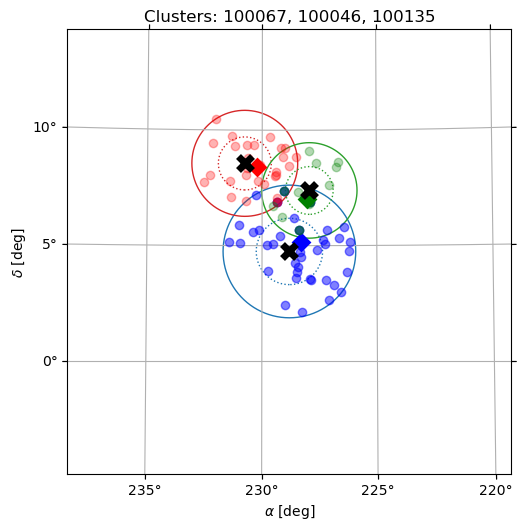

In [50]:
# 100067 overlaps with clusters: [100046, 100135]
sga_1 = SGA[SGA['CLUSTER_ID']==100067]
sga_2 = SGA[SGA['CLUSTER_ID']==100046]
sga_3 = SGA[SGA['CLUSTER_ID']==100135]

plot_triple_cluster_members(clusters, 100067, 100046, 100135, SGA, sga_1['SGA_ID'], sga_2['SGA_ID'], sga_3['SGA_ID'])

In [176]:
# cluster1=[100004,100004,100004,100952,103175,100282,100282,100282,100282,100067,101434,101434,101434,100041,100046,100527,100049,101400,100800,100526,100168]
# cluster2=[100110,100041,100070,103186,103332,100952,103175,103332,101434,100135,103175,103332,103203,100110,100067,101591,100302,101823,103584,100617,100525]

In [70]:
cluster1 = [
100046 , 
100049 , 
100282 , 
101400 , 
100004 , 
100526 ] 

cluster2 = [
100067 ,
100302 ,
100952 ,
101823 ,
100041 ,
100617 ]

<SkyCoord (ICRS): (ra, dec) in deg
    (230.75880839, 8.56052159)>
10914.403364487573 +/- 714 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 954 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (202.38336873, 11.41312599)>
7177.94291271363 +/- 452 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (201.07184081, 13.94308421)>
7311.3908348341865 +/- 368 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 2071 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (237.40360234, 26.00827914)>
22803.420720004207 +/- 1984 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (160.81499432, 1.91346557)>
22387.211385683422 +/- 1711 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (159.82603928, 4.85617483)>
21978.598727848275 +/- 1636 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (246.98584602, 40.22479396)>
9418.895965228417 +/- 1057 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (244.29362068, 35.02777805)>
9418.895965228417 +/- 627 km/s
<Sk

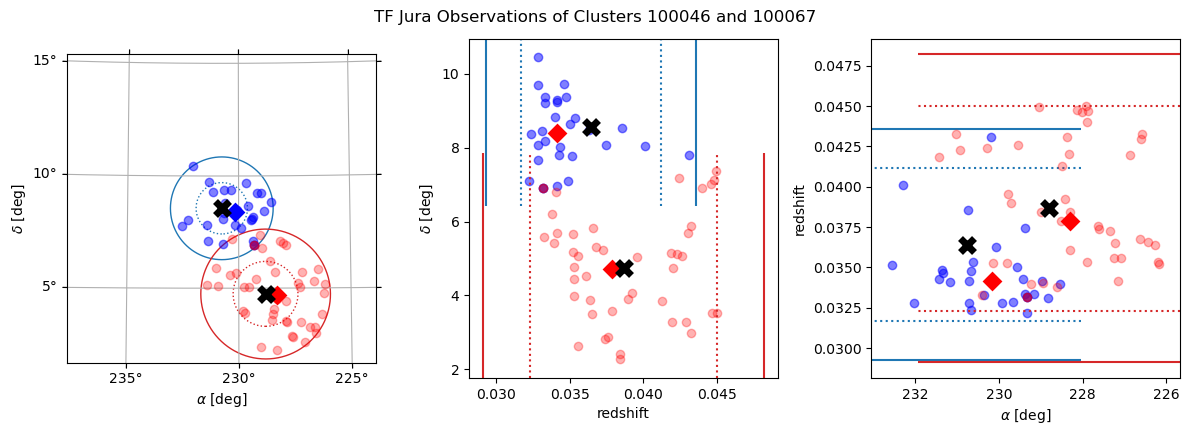

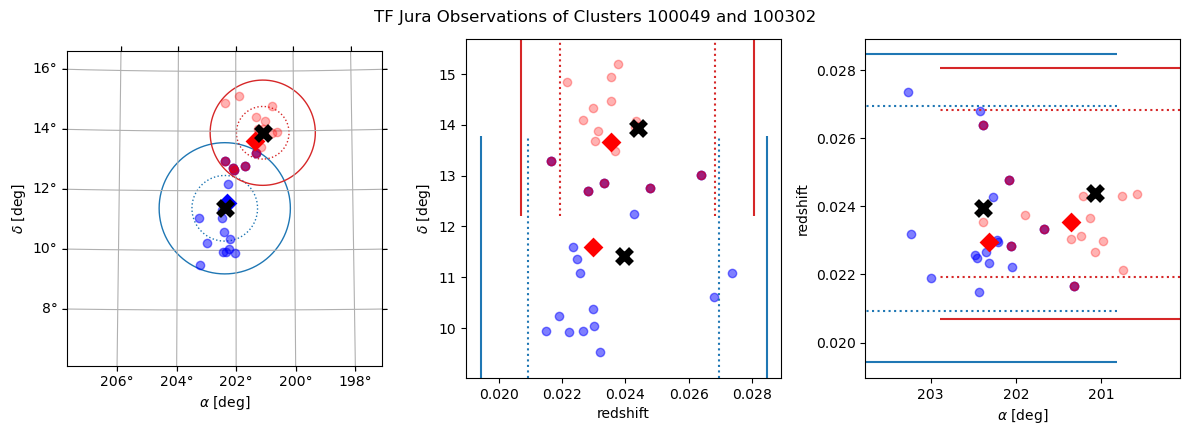

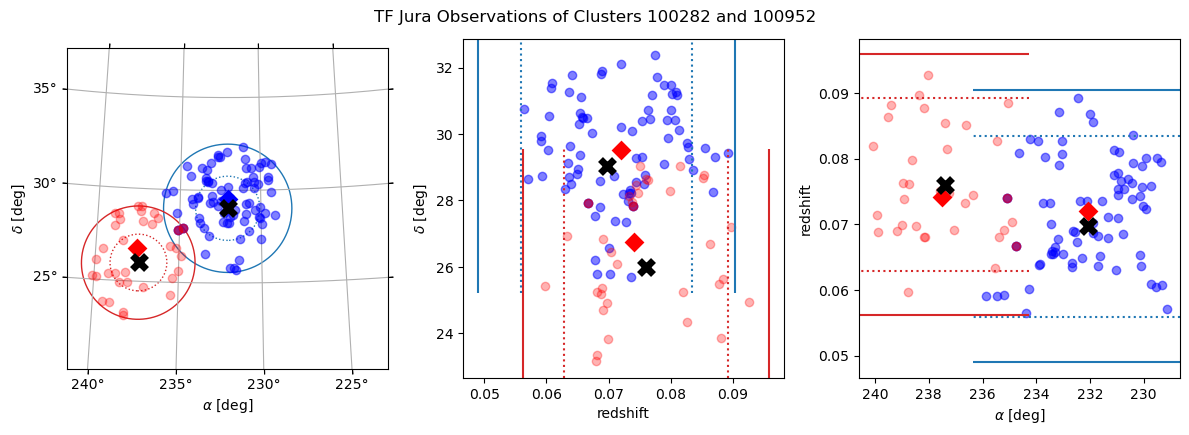

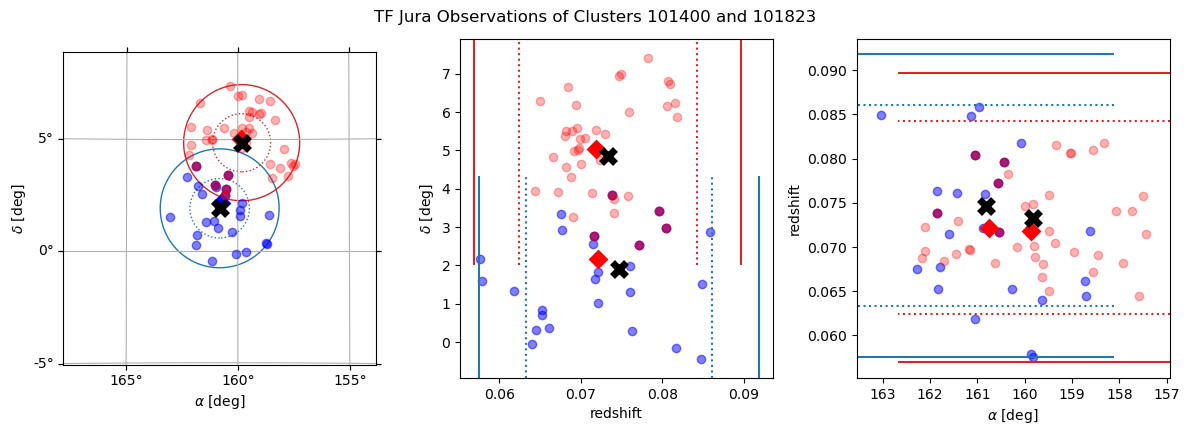

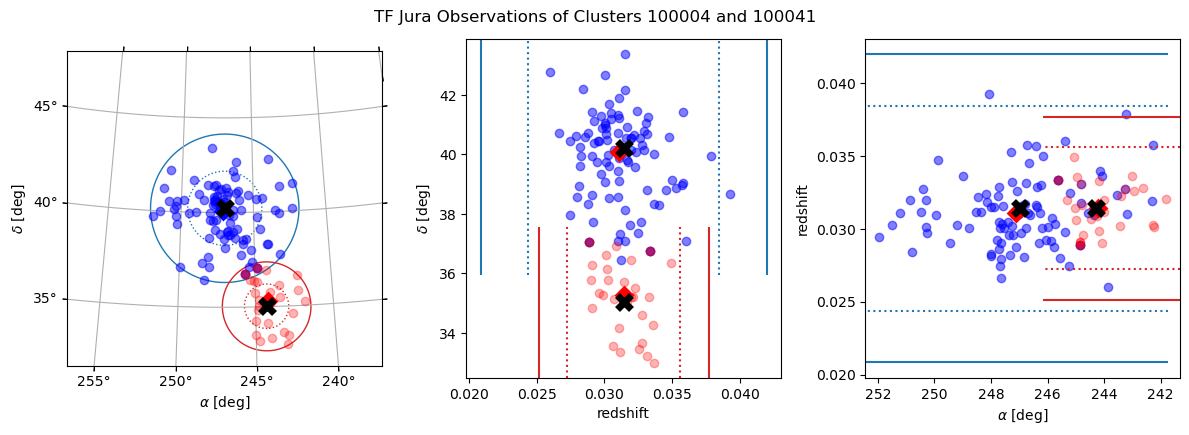

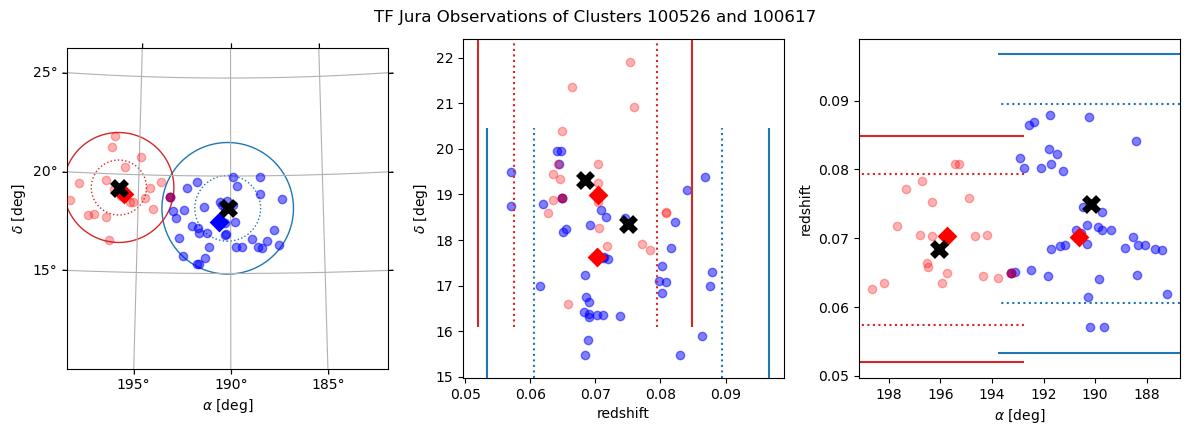

In [71]:
i=0


while i < len(cluster1):
    sga_1 = SGA[SGA['CLUSTER_ID']==cluster1[i]]
    sga_2 = SGA[SGA['CLUSTER_ID']==cluster2[i]]
    
    fig = plot_double_cluster_members(clusters, cluster1[i], cluster2[i], SGA, sga_1['SGA_ID'], sga_2['SGA_ID'])
    fig.savefig(f'Figures/TF_Y3_cluster_overlap_{cluster1[i]}_{cluster2[i]}', dpi=150);
    i+=1

In [188]:
sga_1

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,CLUSTER_ID
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,int32
761,SGA-2020 761,PGC2124331,2124331,245.779107,38.3412843,S?,126.35,0.37931496,0.38282475,0.02875189,24.266481,17.743,False,LEDA-20181114,215,PGC2124331,1,True,245.779107,38.3412843,0.37931496,2458p382,245.77910514417866,38.34129902721367,0.658071,SB26,124.564224,0.32319182,245.7790024718725,38.34136650665185,13.053121,6.714251,6.2390046,5.84362,6.4117727,8.609017,10.602186,11.909309,13.033529,14.184758,15.220757,17.676575,19.74213,18.026365,17.18771,16.650698,17.702948,16.875063,16.343647,17.507347,16.688942,16.16051,17.413507,16.596327,16.079664,17.34833,16.55872,16.053045,17.303328,16.517853,16.030941,17.284056,16.503609,16.020493,17.248598,16.482084,16.005566,17.234013,16.470325,15.999225,0.10197908,0.13490468,0.25322494,0.17365545,0.10943003,0.12833115,0.21649462,0.27748483,0.18866985,0.053782266,0.058268037,0.061345633,0.04634789,0.05001401,0.052562416,0.04191638,0.045257825,0.04746368,0.039738998,0.04284585,0.045189332,0.03820397,0.041750528,0.044285223,0.037093215,0.04056332,0.043528788,0.036540892,0.040081706,0.043154206,0.03552786,0.039334748,0.042594504,0.035083693,0.038935795,0.04237069,17.221521,0.17459138,5.8756886,6.3414946,0.0509277,16.464487,0.1675493,4.0033264,6.5568147,0.053822994,15.999693,0.14480115,3.105526,7.5545564,0.047131658,0,0.028777507415299157,2.2446661471293577e-05,61.722832281339095,19.56891007723405,100004
11814,SGA-2020 11814,PGC2130923,2130923,247.

In [199]:
i

21